In [14]:
import numpy as np
import pandas as pd
#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
jtplot.style(theme='monokai') 
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# import data
train = pd.read_csv("C:/Users/owner/Kaggle/HousePrice/train.csv")
test = pd.read_csv("C:/Users/owner/Kaggle/HousePrice/test.csv")

# Data Process------------------------------------------------
# label encode
for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))
# keep ID for submission
train_ID = train['Id']
test_ID = test['Id']
# split data for training
X = train.drop(['Id','SalePrice'], axis=1)
Y = train['SalePrice']
Z_test = test.drop('Id', axis=1)

In [15]:
# dealing with missing data
X = X.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
X = X.fillna(X.median())
X["TotalSF"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
Z_test = Z_test.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
Z_test = Z_test.fillna(Z_test.median())
Z_test["TotalSF"] = Z_test["TotalBsmtSF"] + Z_test["1stFlrSF"] + Z_test["2ndFlrSF"]
# split data for train_train&test
X_train, Y_train, X_target, Y_target = train_test_split(X,Y,random_state=0, test_size=0.2)
print(X_train.shape, Y_train.shape, X_target.shape, Y_target.shape)

(1168, 77) (292, 77) (1168,) (292,)


In [16]:
# feature importance using random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_features='auto')
rf.fit(X_train, X_target)

# make rankings
use_lbl = 30
ranking = np.argsort(-rf.feature_importances_)
# f, ax = plt.subplots(figsize=(11, 7))
# sns.barplot(x=rf.feature_importances_[ranking[:use_lbl]], y=X_train.columns.values[ranking[:30]])
# ax.set_xlabel("feature importance")
# plt.tight_layout()
# plt.show()
X_train = X_train.iloc[:,ranking[:use_lbl]]
Y_train = Y_train.iloc[:,ranking[:use_lbl]]
Z_test = Z_test.iloc[:,ranking[:use_lbl]]

In [17]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
X_target = np.log(X_target)
Y_taeget = np.log(Y_target)
# make predict_tree
#特徴量と目的変数をxgboostのデータ構造に変換する
dtrain = xgb.DMatrix(X_train, label=X_target)
dvalid = xgb.DMatrix(Y_train, label=Y_target)
#パラメータを指定してGBDT
num_round = 5000
evallist = [(dvalid, 'eval'), (dtrain, 'train')]
evals_result = {}
#パラメータ
param = {
            'max_depth': 3,
            'eta': 0.01,
            'objective': 'reg:squarederror',
}
#学習の実行
bst = xgb.train(
                        param, dtrain,
                        num_round,
                        evallist,
                        evals_result=evals_result,
                        # 一定ラウンド回しても改善が見込めない場合は学習を打ち切る
                        early_stopping_rounds=1000
)

[0]	eval-rmse:199501	train-rmse:11.4153
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 1000 rounds.
[1]	eval-rmse:199501	train-rmse:11.3014
[2]	eval-rmse:199501	train-rmse:11.1886
[3]	eval-rmse:199501	train-rmse:11.077
[4]	eval-rmse:199501	train-rmse:10.9664
[5]	eval-rmse:199501	train-rmse:10.857
[6]	eval-rmse:199501	train-rmse:10.7487
[7]	eval-rmse:199501	train-rmse:10.6414
[8]	eval-rmse:199501	train-rmse:10.5353
[9]	eval-rmse:199501	train-rmse:10.4302
[10]	eval-rmse:199500	train-rmse:10.3261
[11]	eval-rmse:199500	train-rmse:10.2231
[12]	eval-rmse:199500	train-rmse:10.1211
[13]	eval-rmse:199500	train-rmse:10.0201
[14]	eval-rmse:199500	train-rmse:9.92018
[15]	eval-rmse:199500	train-rmse:9.82123
[16]	eval-rmse:199500	train-rmse:9.72327
[17]	eval-rmse:199500	train-rmse:9.62628
[18]	eval-rmse:199500	train-rmse:9.53027
[19]	eval-rmse:199500	train-rmse:9.43522
[20]	eval-rmse:199500	train-rmse:9.34112
[21]

[195]	eval-rmse:199492	train-rmse:1.62824
[196]	eval-rmse:199492	train-rmse:1.6122
[197]	eval-rmse:199492	train-rmse:1.59631
[198]	eval-rmse:199492	train-rmse:1.58059
[199]	eval-rmse:199492	train-rmse:1.56502
[200]	eval-rmse:199492	train-rmse:1.54961
[201]	eval-rmse:199492	train-rmse:1.53435
[202]	eval-rmse:199492	train-rmse:1.51925
[203]	eval-rmse:199492	train-rmse:1.5043
[204]	eval-rmse:199492	train-rmse:1.4895
[205]	eval-rmse:199492	train-rmse:1.47484
[206]	eval-rmse:199492	train-rmse:1.46033
[207]	eval-rmse:199492	train-rmse:1.44597
[208]	eval-rmse:199492	train-rmse:1.43176
[209]	eval-rmse:199492	train-rmse:1.41768
[210]	eval-rmse:199492	train-rmse:1.40375
[211]	eval-rmse:199492	train-rmse:1.38995
[212]	eval-rmse:199492	train-rmse:1.37629
[213]	eval-rmse:199492	train-rmse:1.36277
[214]	eval-rmse:199492	train-rmse:1.34939
[215]	eval-rmse:199492	train-rmse:1.33615
[216]	eval-rmse:199492	train-rmse:1.32303
[217]	eval-rmse:199492	train-rmse:1.31005
[218]	eval-rmse:199492	train-rmse:1.2

[388]	eval-rmse:199491	train-rmse:0.265309
[389]	eval-rmse:199491	train-rmse:0.263149
[390]	eval-rmse:199491	train-rmse:0.261025
[391]	eval-rmse:199491	train-rmse:0.258914
[392]	eval-rmse:199491	train-rmse:0.256838
[393]	eval-rmse:199491	train-rmse:0.25478
[394]	eval-rmse:199491	train-rmse:0.252738
[395]	eval-rmse:199491	train-rmse:0.250722
[396]	eval-rmse:199491	train-rmse:0.248743
[397]	eval-rmse:199491	train-rmse:0.246773
[398]	eval-rmse:199491	train-rmse:0.24483
[399]	eval-rmse:199491	train-rmse:0.242914
[400]	eval-rmse:199491	train-rmse:0.241008
[401]	eval-rmse:199491	train-rmse:0.239124
[402]	eval-rmse:199491	train-rmse:0.237268
[403]	eval-rmse:199491	train-rmse:0.235435
[404]	eval-rmse:199491	train-rmse:0.233619
[405]	eval-rmse:199491	train-rmse:0.231833
[406]	eval-rmse:199491	train-rmse:0.230064
[407]	eval-rmse:199491	train-rmse:0.228308
[408]	eval-rmse:199491	train-rmse:0.226578
[409]	eval-rmse:199491	train-rmse:0.22487
[410]	eval-rmse:199491	train-rmse:0.223175
[411]	eval-rms

[579]	eval-rmse:199491	train-rmse:0.106432
[580]	eval-rmse:199491	train-rmse:0.106243
[581]	eval-rmse:199491	train-rmse:0.106063
[582]	eval-rmse:199491	train-rmse:0.105884
[583]	eval-rmse:199491	train-rmse:0.105715
[584]	eval-rmse:199491	train-rmse:0.105537
[585]	eval-rmse:199491	train-rmse:0.10536
[586]	eval-rmse:199491	train-rmse:0.105191
[587]	eval-rmse:199491	train-rmse:0.105015
[588]	eval-rmse:199491	train-rmse:0.104821
[589]	eval-rmse:199491	train-rmse:0.104661
[590]	eval-rmse:199491	train-rmse:0.104496
[591]	eval-rmse:199491	train-rmse:0.104333
[592]	eval-rmse:199491	train-rmse:0.104176
[593]	eval-rmse:199491	train-rmse:0.10402
[594]	eval-rmse:199491	train-rmse:0.103865
[595]	eval-rmse:199491	train-rmse:0.103685
[596]	eval-rmse:199491	train-rmse:0.103532
[597]	eval-rmse:199491	train-rmse:0.103387
[598]	eval-rmse:199491	train-rmse:0.103232
[599]	eval-rmse:199491	train-rmse:0.103088
[600]	eval-rmse:199491	train-rmse:0.102958
[601]	eval-rmse:199491	train-rmse:0.102818
[602]	eval-rm

[771]	eval-rmse:199491	train-rmse:0.090779
[772]	eval-rmse:199491	train-rmse:0.090744
[773]	eval-rmse:199491	train-rmse:0.090707
[774]	eval-rmse:199491	train-rmse:0.090662
[775]	eval-rmse:199491	train-rmse:0.090621
[776]	eval-rmse:199491	train-rmse:0.090593
[777]	eval-rmse:199491	train-rmse:0.090557
[778]	eval-rmse:199491	train-rmse:0.090519
[779]	eval-rmse:199491	train-rmse:0.090486
[780]	eval-rmse:199491	train-rmse:0.09045
[781]	eval-rmse:199491	train-rmse:0.090418
[782]	eval-rmse:199491	train-rmse:0.090382
[783]	eval-rmse:199491	train-rmse:0.090339
[784]	eval-rmse:199491	train-rmse:0.090312
[785]	eval-rmse:199491	train-rmse:0.090279
[786]	eval-rmse:199491	train-rmse:0.09024
[787]	eval-rmse:199491	train-rmse:0.090207
[788]	eval-rmse:199491	train-rmse:0.090165
[789]	eval-rmse:199491	train-rmse:0.090139
[790]	eval-rmse:199491	train-rmse:0.090107
[791]	eval-rmse:199491	train-rmse:0.090071
[792]	eval-rmse:199491	train-rmse:0.090045
[793]	eval-rmse:199491	train-rmse:0.090003
[794]	eval-rm

[963]	eval-rmse:199491	train-rmse:0.085547
[964]	eval-rmse:199491	train-rmse:0.085509
[965]	eval-rmse:199491	train-rmse:0.08549
[966]	eval-rmse:199491	train-rmse:0.085475
[967]	eval-rmse:199491	train-rmse:0.085445
[968]	eval-rmse:199491	train-rmse:0.085429
[969]	eval-rmse:199491	train-rmse:0.08541
[970]	eval-rmse:199491	train-rmse:0.085387
[971]	eval-rmse:199491	train-rmse:0.085367
[972]	eval-rmse:199491	train-rmse:0.085351
[973]	eval-rmse:199491	train-rmse:0.085337
[974]	eval-rmse:199491	train-rmse:0.085312
[975]	eval-rmse:199491	train-rmse:0.08529
[976]	eval-rmse:199491	train-rmse:0.085263
[977]	eval-rmse:199491	train-rmse:0.085243
[978]	eval-rmse:199491	train-rmse:0.085213
[979]	eval-rmse:199491	train-rmse:0.085175
[980]	eval-rmse:199491	train-rmse:0.085155
[981]	eval-rmse:199491	train-rmse:0.085113
[982]	eval-rmse:199491	train-rmse:0.085096
[983]	eval-rmse:199491	train-rmse:0.085077
[984]	eval-rmse:199491	train-rmse:0.085058
[985]	eval-rmse:199491	train-rmse:0.085035
[986]	eval-rms

[1151]	eval-rmse:199491	train-rmse:0.081569
[1152]	eval-rmse:199491	train-rmse:0.081548
[1153]	eval-rmse:199491	train-rmse:0.081535
[1154]	eval-rmse:199491	train-rmse:0.08152
[1155]	eval-rmse:199491	train-rmse:0.081496
[1156]	eval-rmse:199491	train-rmse:0.081476
[1157]	eval-rmse:199491	train-rmse:0.08146
[1158]	eval-rmse:199491	train-rmse:0.081441
[1159]	eval-rmse:199491	train-rmse:0.081423
[1160]	eval-rmse:199491	train-rmse:0.081395
[1161]	eval-rmse:199491	train-rmse:0.081373
[1162]	eval-rmse:199491	train-rmse:0.081341
[1163]	eval-rmse:199491	train-rmse:0.081321
[1164]	eval-rmse:199491	train-rmse:0.081289
[1165]	eval-rmse:199491	train-rmse:0.081276
[1166]	eval-rmse:199491	train-rmse:0.081261
[1167]	eval-rmse:199491	train-rmse:0.08124
[1168]	eval-rmse:199491	train-rmse:0.081214
[1169]	eval-rmse:199491	train-rmse:0.0812
[1170]	eval-rmse:199491	train-rmse:0.081188
[1171]	eval-rmse:199491	train-rmse:0.081173
[1172]	eval-rmse:199491	train-rmse:0.08115
[1173]	eval-rmse:199491	train-rmse:0.0

[1338]	eval-rmse:199491	train-rmse:0.078143
[1339]	eval-rmse:199491	train-rmse:0.078134
[1340]	eval-rmse:199491	train-rmse:0.078109
[1341]	eval-rmse:199491	train-rmse:0.078085
[1342]	eval-rmse:199491	train-rmse:0.078059
[1343]	eval-rmse:199491	train-rmse:0.078032
[1344]	eval-rmse:199491	train-rmse:0.078023
[1345]	eval-rmse:199491	train-rmse:0.078006
[1346]	eval-rmse:199491	train-rmse:0.077981
[1347]	eval-rmse:199491	train-rmse:0.077965
[1348]	eval-rmse:199491	train-rmse:0.077956
[1349]	eval-rmse:199491	train-rmse:0.077944
[1350]	eval-rmse:199491	train-rmse:0.077927
[1351]	eval-rmse:199491	train-rmse:0.077918
[1352]	eval-rmse:199491	train-rmse:0.077909
[1353]	eval-rmse:199491	train-rmse:0.0779
[1354]	eval-rmse:199491	train-rmse:0.077875
[1355]	eval-rmse:199491	train-rmse:0.07786
[1356]	eval-rmse:199491	train-rmse:0.077844
[1357]	eval-rmse:199491	train-rmse:0.077835
[1358]	eval-rmse:199491	train-rmse:0.077817
[1359]	eval-rmse:199491	train-rmse:0.077796
[1360]	eval-rmse:199491	train-rmse:

[1525]	eval-rmse:199491	train-rmse:0.074988
[1526]	eval-rmse:199491	train-rmse:0.07497
[1527]	eval-rmse:199491	train-rmse:0.074963
[1528]	eval-rmse:199491	train-rmse:0.074937
[1529]	eval-rmse:199491	train-rmse:0.074925
[1530]	eval-rmse:199491	train-rmse:0.074905
[1531]	eval-rmse:199491	train-rmse:0.074884
[1532]	eval-rmse:199491	train-rmse:0.074873
[1533]	eval-rmse:199491	train-rmse:0.074846
[1534]	eval-rmse:199491	train-rmse:0.074837
[1535]	eval-rmse:199491	train-rmse:0.074815
[1536]	eval-rmse:199491	train-rmse:0.074795
[1537]	eval-rmse:199491	train-rmse:0.074787
[1538]	eval-rmse:199491	train-rmse:0.07478
[1539]	eval-rmse:199491	train-rmse:0.07476
[1540]	eval-rmse:199491	train-rmse:0.074755
[1541]	eval-rmse:199491	train-rmse:0.074739
[1542]	eval-rmse:199491	train-rmse:0.07472
[1543]	eval-rmse:199491	train-rmse:0.074712
[1544]	eval-rmse:199491	train-rmse:0.074706
[1545]	eval-rmse:199491	train-rmse:0.074701
[1546]	eval-rmse:199491	train-rmse:0.07468
[1547]	eval-rmse:199491	train-rmse:0.

[1712]	eval-rmse:199491	train-rmse:0.072384
[1713]	eval-rmse:199491	train-rmse:0.072374
[1714]	eval-rmse:199491	train-rmse:0.072362
[1715]	eval-rmse:199491	train-rmse:0.072337
[1716]	eval-rmse:199491	train-rmse:0.07233
[1717]	eval-rmse:199491	train-rmse:0.072313
[1718]	eval-rmse:199491	train-rmse:0.072297
[1719]	eval-rmse:199491	train-rmse:0.072285
[1720]	eval-rmse:199491	train-rmse:0.072281
[1721]	eval-rmse:199491	train-rmse:0.072272
[1722]	eval-rmse:199491	train-rmse:0.072258
[1723]	eval-rmse:199491	train-rmse:0.07225
[1724]	eval-rmse:199491	train-rmse:0.072242
[1725]	eval-rmse:199491	train-rmse:0.072237
[1726]	eval-rmse:199491	train-rmse:0.072225
[1727]	eval-rmse:199491	train-rmse:0.072205
[1728]	eval-rmse:199491	train-rmse:0.072185
[1729]	eval-rmse:199491	train-rmse:0.072166
[1730]	eval-rmse:199491	train-rmse:0.072144
[1731]	eval-rmse:199491	train-rmse:0.07214
[1732]	eval-rmse:199491	train-rmse:0.072123
[1733]	eval-rmse:199491	train-rmse:0.072106
[1734]	eval-rmse:199491	train-rmse:

[1899]	eval-rmse:199491	train-rmse:0.069867
[1900]	eval-rmse:199491	train-rmse:0.069849
[1901]	eval-rmse:199491	train-rmse:0.069831
[1902]	eval-rmse:199491	train-rmse:0.069818
[1903]	eval-rmse:199491	train-rmse:0.069811
[1904]	eval-rmse:199491	train-rmse:0.06979
[1905]	eval-rmse:199491	train-rmse:0.069778
[1906]	eval-rmse:199491	train-rmse:0.069773
[1907]	eval-rmse:199491	train-rmse:0.069756
[1908]	eval-rmse:199491	train-rmse:0.06974
[1909]	eval-rmse:199491	train-rmse:0.069736
[1910]	eval-rmse:199491	train-rmse:0.069723
[1911]	eval-rmse:199491	train-rmse:0.069717
[1912]	eval-rmse:199491	train-rmse:0.069693
[1913]	eval-rmse:199491	train-rmse:0.069676
[1914]	eval-rmse:199491	train-rmse:0.069666
[1915]	eval-rmse:199491	train-rmse:0.069648
[1916]	eval-rmse:199491	train-rmse:0.069636
[1917]	eval-rmse:199491	train-rmse:0.069615
[1918]	eval-rmse:199491	train-rmse:0.069609
[1919]	eval-rmse:199491	train-rmse:0.069591
[1920]	eval-rmse:199491	train-rmse:0.069575
[1921]	eval-rmse:199491	train-rmse

[2086]	eval-rmse:199491	train-rmse:0.067537
[2087]	eval-rmse:199491	train-rmse:0.067521
[2088]	eval-rmse:199491	train-rmse:0.067516
[2089]	eval-rmse:199491	train-rmse:0.067502
[2090]	eval-rmse:199491	train-rmse:0.067487
[2091]	eval-rmse:199491	train-rmse:0.067471
[2092]	eval-rmse:199491	train-rmse:0.067454
[2093]	eval-rmse:199491	train-rmse:0.067451
[2094]	eval-rmse:199491	train-rmse:0.067446
[2095]	eval-rmse:199491	train-rmse:0.067441
[2096]	eval-rmse:199491	train-rmse:0.067437
[2097]	eval-rmse:199491	train-rmse:0.067424
[2098]	eval-rmse:199491	train-rmse:0.067418
[2099]	eval-rmse:199491	train-rmse:0.067407
[2100]	eval-rmse:199491	train-rmse:0.067396
[2101]	eval-rmse:199491	train-rmse:0.067393
[2102]	eval-rmse:199491	train-rmse:0.067388
[2103]	eval-rmse:199491	train-rmse:0.067377
[2104]	eval-rmse:199491	train-rmse:0.067368
[2105]	eval-rmse:199491	train-rmse:0.067352
[2106]	eval-rmse:199491	train-rmse:0.067334
[2107]	eval-rmse:199491	train-rmse:0.06733
[2108]	eval-rmse:199491	train-rms

[2273]	eval-rmse:199491	train-rmse:0.065308
[2274]	eval-rmse:199491	train-rmse:0.06529
[2275]	eval-rmse:199491	train-rmse:0.065288
[2276]	eval-rmse:199491	train-rmse:0.065275
[2277]	eval-rmse:199491	train-rmse:0.065257
[2278]	eval-rmse:199491	train-rmse:0.065248
[2279]	eval-rmse:199491	train-rmse:0.065229
[2280]	eval-rmse:199491	train-rmse:0.065215
[2281]	eval-rmse:199491	train-rmse:0.065207
[2282]	eval-rmse:199491	train-rmse:0.065189
[2283]	eval-rmse:199491	train-rmse:0.065174
[2284]	eval-rmse:199491	train-rmse:0.06516
[2285]	eval-rmse:199491	train-rmse:0.065143
[2286]	eval-rmse:199491	train-rmse:0.065128
[2287]	eval-rmse:199491	train-rmse:0.065112
[2288]	eval-rmse:199491	train-rmse:0.065108
[2289]	eval-rmse:199491	train-rmse:0.065095
[2290]	eval-rmse:199491	train-rmse:0.065092
[2291]	eval-rmse:199491	train-rmse:0.06508
[2292]	eval-rmse:199491	train-rmse:0.065071
[2293]	eval-rmse:199491	train-rmse:0.065052
[2294]	eval-rmse:199491	train-rmse:0.065041
[2295]	eval-rmse:199491	train-rmse:

[2460]	eval-rmse:199491	train-rmse:0.06304
[2461]	eval-rmse:199491	train-rmse:0.063022
[2462]	eval-rmse:199491	train-rmse:0.063002
[2463]	eval-rmse:199491	train-rmse:0.062986
[2464]	eval-rmse:199491	train-rmse:0.062982
[2465]	eval-rmse:199491	train-rmse:0.062972
[2466]	eval-rmse:199491	train-rmse:0.062954
[2467]	eval-rmse:199491	train-rmse:0.062938
[2468]	eval-rmse:199491	train-rmse:0.062936
[2469]	eval-rmse:199491	train-rmse:0.062931
[2470]	eval-rmse:199491	train-rmse:0.062914
[2471]	eval-rmse:199491	train-rmse:0.062911
[2472]	eval-rmse:199491	train-rmse:0.062908
[2473]	eval-rmse:199491	train-rmse:0.062895
[2474]	eval-rmse:199491	train-rmse:0.062883
[2475]	eval-rmse:199491	train-rmse:0.062868
[2476]	eval-rmse:199491	train-rmse:0.062853
[2477]	eval-rmse:199491	train-rmse:0.06285
[2478]	eval-rmse:199491	train-rmse:0.062841
[2479]	eval-rmse:199491	train-rmse:0.062834
[2480]	eval-rmse:199491	train-rmse:0.062812
[2481]	eval-rmse:199491	train-rmse:0.062797
[2482]	eval-rmse:199491	train-rmse

[2647]	eval-rmse:199491	train-rmse:0.060949
[2648]	eval-rmse:199491	train-rmse:0.060931
[2649]	eval-rmse:199491	train-rmse:0.060921
[2650]	eval-rmse:199491	train-rmse:0.060911
[2651]	eval-rmse:199491	train-rmse:0.060908
[2652]	eval-rmse:199491	train-rmse:0.0609
[2653]	eval-rmse:199491	train-rmse:0.06089
[2654]	eval-rmse:199491	train-rmse:0.060872
[2655]	eval-rmse:199491	train-rmse:0.06086
[2656]	eval-rmse:199491	train-rmse:0.060844
[2657]	eval-rmse:199491	train-rmse:0.060837
[2658]	eval-rmse:199491	train-rmse:0.06082
[2659]	eval-rmse:199491	train-rmse:0.060803
[2660]	eval-rmse:199491	train-rmse:0.060791
[2661]	eval-rmse:199491	train-rmse:0.060778
[2662]	eval-rmse:199491	train-rmse:0.06077
[2663]	eval-rmse:199491	train-rmse:0.060757
[2664]	eval-rmse:199491	train-rmse:0.060743
[2665]	eval-rmse:199491	train-rmse:0.06073
[2666]	eval-rmse:199491	train-rmse:0.060711
[2667]	eval-rmse:199491	train-rmse:0.060691
[2668]	eval-rmse:199491	train-rmse:0.060683
[2669]	eval-rmse:199491	train-rmse:0.06

[2834]	eval-rmse:199491	train-rmse:0.058821
[2835]	eval-rmse:199491	train-rmse:0.058814
[2836]	eval-rmse:199491	train-rmse:0.058802
[2837]	eval-rmse:199491	train-rmse:0.058794
[2838]	eval-rmse:199491	train-rmse:0.058776
[2839]	eval-rmse:199491	train-rmse:0.058771
[2840]	eval-rmse:199491	train-rmse:0.058761
[2841]	eval-rmse:199491	train-rmse:0.058749
[2842]	eval-rmse:199491	train-rmse:0.058734
[2843]	eval-rmse:199491	train-rmse:0.058725
[2844]	eval-rmse:199491	train-rmse:0.058715
[2845]	eval-rmse:199491	train-rmse:0.058696
[2846]	eval-rmse:199491	train-rmse:0.058684
[2847]	eval-rmse:199491	train-rmse:0.058674
[2848]	eval-rmse:199491	train-rmse:0.058664
[2849]	eval-rmse:199491	train-rmse:0.058662
[2850]	eval-rmse:199491	train-rmse:0.058657
[2851]	eval-rmse:199491	train-rmse:0.058651
[2852]	eval-rmse:199491	train-rmse:0.058636
[2853]	eval-rmse:199491	train-rmse:0.058618
[2854]	eval-rmse:199491	train-rmse:0.0586
[2855]	eval-rmse:199491	train-rmse:0.058598
[2856]	eval-rmse:199491	train-rmse

[3021]	eval-rmse:199491	train-rmse:0.056962
[3022]	eval-rmse:199491	train-rmse:0.056955
[3023]	eval-rmse:199491	train-rmse:0.056944
[3024]	eval-rmse:199491	train-rmse:0.056938
[3025]	eval-rmse:199491	train-rmse:0.056932
[3026]	eval-rmse:199491	train-rmse:0.05693
[3027]	eval-rmse:199491	train-rmse:0.056926
[3028]	eval-rmse:199491	train-rmse:0.05692
[3029]	eval-rmse:199491	train-rmse:0.056905
[3030]	eval-rmse:199491	train-rmse:0.056895
[3031]	eval-rmse:199491	train-rmse:0.056885
[3032]	eval-rmse:199491	train-rmse:0.056877
[3033]	eval-rmse:199491	train-rmse:0.056867
[3034]	eval-rmse:199491	train-rmse:0.056855
[3035]	eval-rmse:199491	train-rmse:0.056839
[3036]	eval-rmse:199491	train-rmse:0.056835
[3037]	eval-rmse:199491	train-rmse:0.056826
[3038]	eval-rmse:199491	train-rmse:0.056823
[3039]	eval-rmse:199491	train-rmse:0.056817
[3040]	eval-rmse:199491	train-rmse:0.056803
[3041]	eval-rmse:199491	train-rmse:0.056793
[3042]	eval-rmse:199491	train-rmse:0.056786
[3043]	eval-rmse:199491	train-rmse

[3208]	eval-rmse:199491	train-rmse:0.05531
[3209]	eval-rmse:199491	train-rmse:0.055309
[3210]	eval-rmse:199491	train-rmse:0.055299
[3211]	eval-rmse:199491	train-rmse:0.055294
[3212]	eval-rmse:199491	train-rmse:0.055284
[3213]	eval-rmse:199491	train-rmse:0.055271
[3214]	eval-rmse:199491	train-rmse:0.055263
[3215]	eval-rmse:199491	train-rmse:0.055262
[3216]	eval-rmse:199491	train-rmse:0.055252
[3217]	eval-rmse:199491	train-rmse:0.055249
[3218]	eval-rmse:199491	train-rmse:0.055244
[3219]	eval-rmse:199491	train-rmse:0.055234
[3220]	eval-rmse:199491	train-rmse:0.055224
[3221]	eval-rmse:199491	train-rmse:0.055215
[3222]	eval-rmse:199491	train-rmse:0.055204
[3223]	eval-rmse:199491	train-rmse:0.055196
[3224]	eval-rmse:199491	train-rmse:0.055186
[3225]	eval-rmse:199491	train-rmse:0.055176
[3226]	eval-rmse:199491	train-rmse:0.055168
[3227]	eval-rmse:199491	train-rmse:0.055157
[3228]	eval-rmse:199491	train-rmse:0.055155
[3229]	eval-rmse:199491	train-rmse:0.055142
[3230]	eval-rmse:199491	train-rms

[3395]	eval-rmse:199491	train-rmse:0.053847
[3396]	eval-rmse:199491	train-rmse:0.053839
[3397]	eval-rmse:199491	train-rmse:0.05383
[3398]	eval-rmse:199491	train-rmse:0.053818
[3399]	eval-rmse:199491	train-rmse:0.053814
[3400]	eval-rmse:199491	train-rmse:0.053805
[3401]	eval-rmse:199491	train-rmse:0.053803
[3402]	eval-rmse:199491	train-rmse:0.053798
[3403]	eval-rmse:199491	train-rmse:0.053786
[3404]	eval-rmse:199491	train-rmse:0.053782
[3405]	eval-rmse:199491	train-rmse:0.053768
[3406]	eval-rmse:199491	train-rmse:0.053757
[3407]	eval-rmse:199491	train-rmse:0.053749
[3408]	eval-rmse:199491	train-rmse:0.053744
[3409]	eval-rmse:199491	train-rmse:0.053732
[3410]	eval-rmse:199491	train-rmse:0.05373
[3411]	eval-rmse:199491	train-rmse:0.053722
[3412]	eval-rmse:199491	train-rmse:0.053713
[3413]	eval-rmse:199491	train-rmse:0.053704
[3414]	eval-rmse:199491	train-rmse:0.053694
[3415]	eval-rmse:199491	train-rmse:0.053686
[3416]	eval-rmse:199491	train-rmse:0.05368
[3417]	eval-rmse:199491	train-rmse:

[3582]	eval-rmse:199491	train-rmse:0.052299
[3583]	eval-rmse:199491	train-rmse:0.052291
[3584]	eval-rmse:199491	train-rmse:0.052283
[3585]	eval-rmse:199491	train-rmse:0.052275
[3586]	eval-rmse:199491	train-rmse:0.052267
[3587]	eval-rmse:199491	train-rmse:0.052259
[3588]	eval-rmse:199491	train-rmse:0.052252
[3589]	eval-rmse:199491	train-rmse:0.052241
[3590]	eval-rmse:199491	train-rmse:0.05223
[3591]	eval-rmse:199491	train-rmse:0.052219
[3592]	eval-rmse:199491	train-rmse:0.052212
[3593]	eval-rmse:199491	train-rmse:0.05221
[3594]	eval-rmse:199491	train-rmse:0.052207
[3595]	eval-rmse:199491	train-rmse:0.052197
[3596]	eval-rmse:199491	train-rmse:0.05219
[3597]	eval-rmse:199491	train-rmse:0.052183
[3598]	eval-rmse:199491	train-rmse:0.052173
[3599]	eval-rmse:199491	train-rmse:0.052166
[3600]	eval-rmse:199491	train-rmse:0.052159
[3601]	eval-rmse:199491	train-rmse:0.052151
[3602]	eval-rmse:199491	train-rmse:0.052143
[3603]	eval-rmse:199491	train-rmse:0.052135
[3604]	eval-rmse:199491	train-rmse:

[3769]	eval-rmse:199491	train-rmse:0.050879
[3770]	eval-rmse:199491	train-rmse:0.050877
[3771]	eval-rmse:199491	train-rmse:0.050866
[3772]	eval-rmse:199491	train-rmse:0.050855
[3773]	eval-rmse:199491	train-rmse:0.050842
[3774]	eval-rmse:199491	train-rmse:0.050835
[3775]	eval-rmse:199491	train-rmse:0.050825
[3776]	eval-rmse:199491	train-rmse:0.050819
[3777]	eval-rmse:199491	train-rmse:0.050812
[3778]	eval-rmse:199491	train-rmse:0.050798
[3779]	eval-rmse:199491	train-rmse:0.050788
[3780]	eval-rmse:199491	train-rmse:0.050779
[3781]	eval-rmse:199491	train-rmse:0.050769
[3782]	eval-rmse:199491	train-rmse:0.050766
[3783]	eval-rmse:199491	train-rmse:0.050757
[3784]	eval-rmse:199491	train-rmse:0.05075
[3785]	eval-rmse:199491	train-rmse:0.050744
[3786]	eval-rmse:199491	train-rmse:0.050738
[3787]	eval-rmse:199491	train-rmse:0.050733
[3788]	eval-rmse:199491	train-rmse:0.050721
[3789]	eval-rmse:199491	train-rmse:0.05072
[3790]	eval-rmse:199491	train-rmse:0.050714
[3791]	eval-rmse:199491	train-rmse

[3956]	eval-rmse:199491	train-rmse:0.049502
[3957]	eval-rmse:199491	train-rmse:0.049495
[3958]	eval-rmse:199491	train-rmse:0.049488
[3959]	eval-rmse:199491	train-rmse:0.049484
[3960]	eval-rmse:199491	train-rmse:0.049476
[3961]	eval-rmse:199491	train-rmse:0.049474
[3962]	eval-rmse:199491	train-rmse:0.049473
[3963]	eval-rmse:199491	train-rmse:0.049462
[3964]	eval-rmse:199491	train-rmse:0.049451
[3965]	eval-rmse:199491	train-rmse:0.04944
[3966]	eval-rmse:199491	train-rmse:0.049426
[3967]	eval-rmse:199491	train-rmse:0.049418
[3968]	eval-rmse:199491	train-rmse:0.04941
[3969]	eval-rmse:199491	train-rmse:0.049405
[3970]	eval-rmse:199491	train-rmse:0.049394
[3971]	eval-rmse:199491	train-rmse:0.049392
[3972]	eval-rmse:199491	train-rmse:0.049386
[3973]	eval-rmse:199491	train-rmse:0.049379
[3974]	eval-rmse:199491	train-rmse:0.049374
[3975]	eval-rmse:199491	train-rmse:0.049365
[3976]	eval-rmse:199491	train-rmse:0.049354
[3977]	eval-rmse:199491	train-rmse:0.049349
[3978]	eval-rmse:199491	train-rmse

[4143]	eval-rmse:199491	train-rmse:0.048114
[4144]	eval-rmse:199491	train-rmse:0.048107
[4145]	eval-rmse:199491	train-rmse:0.048106
[4146]	eval-rmse:199491	train-rmse:0.048102
[4147]	eval-rmse:199491	train-rmse:0.04809
[4148]	eval-rmse:199491	train-rmse:0.048087
[4149]	eval-rmse:199491	train-rmse:0.048085
[4150]	eval-rmse:199491	train-rmse:0.04808
[4151]	eval-rmse:199491	train-rmse:0.048076
[4152]	eval-rmse:199491	train-rmse:0.048067
[4153]	eval-rmse:199491	train-rmse:0.048061
[4154]	eval-rmse:199491	train-rmse:0.04806
[4155]	eval-rmse:199491	train-rmse:0.048057
[4156]	eval-rmse:199491	train-rmse:0.04805
[4157]	eval-rmse:199491	train-rmse:0.048044
[4158]	eval-rmse:199491	train-rmse:0.048035
[4159]	eval-rmse:199491	train-rmse:0.048024
[4160]	eval-rmse:199491	train-rmse:0.048014
[4161]	eval-rmse:199491	train-rmse:0.048009
[4162]	eval-rmse:199491	train-rmse:0.048
[4163]	eval-rmse:199491	train-rmse:0.047995
[4164]	eval-rmse:199491	train-rmse:0.047988
[4165]	eval-rmse:199491	train-rmse:0.04

[4330]	eval-rmse:199491	train-rmse:0.04693
[4331]	eval-rmse:199491	train-rmse:0.046926
[4332]	eval-rmse:199491	train-rmse:0.046917
[4333]	eval-rmse:199491	train-rmse:0.04691
[4334]	eval-rmse:199491	train-rmse:0.0469
[4335]	eval-rmse:199491	train-rmse:0.046887
[4336]	eval-rmse:199491	train-rmse:0.046879
[4337]	eval-rmse:199491	train-rmse:0.046876
[4338]	eval-rmse:199491	train-rmse:0.046863
[4339]	eval-rmse:199491	train-rmse:0.046856
[4340]	eval-rmse:199491	train-rmse:0.046852
[4341]	eval-rmse:199491	train-rmse:0.046844
[4342]	eval-rmse:199491	train-rmse:0.046833
[4343]	eval-rmse:199491	train-rmse:0.046828
[4344]	eval-rmse:199491	train-rmse:0.046818
[4345]	eval-rmse:199491	train-rmse:0.046805
[4346]	eval-rmse:199491	train-rmse:0.046798
[4347]	eval-rmse:199491	train-rmse:0.046794
[4348]	eval-rmse:199491	train-rmse:0.046787
[4349]	eval-rmse:199491	train-rmse:0.046776
[4350]	eval-rmse:199491	train-rmse:0.046772
[4351]	eval-rmse:199491	train-rmse:0.04676
[4352]	eval-rmse:199491	train-rmse:0.

[4517]	eval-rmse:199491	train-rmse:0.045696
[4518]	eval-rmse:199491	train-rmse:0.045685
[4519]	eval-rmse:199491	train-rmse:0.045678
[4520]	eval-rmse:199491	train-rmse:0.045674
[4521]	eval-rmse:199491	train-rmse:0.045669
[4522]	eval-rmse:199491	train-rmse:0.045663
[4523]	eval-rmse:199491	train-rmse:0.045659
[4524]	eval-rmse:199491	train-rmse:0.04565
[4525]	eval-rmse:199491	train-rmse:0.045643
[4526]	eval-rmse:199491	train-rmse:0.045639
[4527]	eval-rmse:199491	train-rmse:0.04563
[4528]	eval-rmse:199491	train-rmse:0.045624
[4529]	eval-rmse:199491	train-rmse:0.045616
[4530]	eval-rmse:199491	train-rmse:0.0456
[4531]	eval-rmse:199491	train-rmse:0.045591
[4532]	eval-rmse:199491	train-rmse:0.045586
[4533]	eval-rmse:199491	train-rmse:0.045582
[4534]	eval-rmse:199491	train-rmse:0.045579
[4535]	eval-rmse:199491	train-rmse:0.045572
[4536]	eval-rmse:199491	train-rmse:0.04557
[4537]	eval-rmse:199491	train-rmse:0.045568
[4538]	eval-rmse:199491	train-rmse:0.045557
[4539]	eval-rmse:199491	train-rmse:0.

[4704]	eval-rmse:199491	train-rmse:0.044459
[4705]	eval-rmse:199491	train-rmse:0.044456
[4706]	eval-rmse:199491	train-rmse:0.04445
[4707]	eval-rmse:199491	train-rmse:0.044446
[4708]	eval-rmse:199491	train-rmse:0.044431
[4709]	eval-rmse:199491	train-rmse:0.044424
[4710]	eval-rmse:199491	train-rmse:0.044419
[4711]	eval-rmse:199491	train-rmse:0.044414
[4712]	eval-rmse:199491	train-rmse:0.044407
[4713]	eval-rmse:199491	train-rmse:0.044404
[4714]	eval-rmse:199491	train-rmse:0.044397
[4715]	eval-rmse:199491	train-rmse:0.044391
[4716]	eval-rmse:199491	train-rmse:0.044388
[4717]	eval-rmse:199491	train-rmse:0.044374
[4718]	eval-rmse:199491	train-rmse:0.044367
[4719]	eval-rmse:199491	train-rmse:0.044364
[4720]	eval-rmse:199491	train-rmse:0.044356
[4721]	eval-rmse:199491	train-rmse:0.044349
[4722]	eval-rmse:199491	train-rmse:0.044342
[4723]	eval-rmse:199491	train-rmse:0.044335
[4724]	eval-rmse:199491	train-rmse:0.044331
[4725]	eval-rmse:199491	train-rmse:0.044324
[4726]	eval-rmse:199491	train-rms

[4891]	eval-rmse:199491	train-rmse:0.043118
[4892]	eval-rmse:199491	train-rmse:0.04311
[4893]	eval-rmse:199491	train-rmse:0.043102
[4894]	eval-rmse:199491	train-rmse:0.043096
[4895]	eval-rmse:199491	train-rmse:0.043094
[4896]	eval-rmse:199491	train-rmse:0.043088
[4897]	eval-rmse:199491	train-rmse:0.043079
[4898]	eval-rmse:199491	train-rmse:0.043068
[4899]	eval-rmse:199491	train-rmse:0.043058
[4900]	eval-rmse:199491	train-rmse:0.043054
[4901]	eval-rmse:199491	train-rmse:0.043048
[4902]	eval-rmse:199491	train-rmse:0.043039
[4903]	eval-rmse:199491	train-rmse:0.04303
[4904]	eval-rmse:199491	train-rmse:0.043024
[4905]	eval-rmse:199491	train-rmse:0.04302
[4906]	eval-rmse:199491	train-rmse:0.043009
[4907]	eval-rmse:199491	train-rmse:0.043004
[4908]	eval-rmse:199491	train-rmse:0.043
[4909]	eval-rmse:199491	train-rmse:0.042998
[4910]	eval-rmse:199491	train-rmse:0.042991
[4911]	eval-rmse:199491	train-rmse:0.042982
[4912]	eval-rmse:199491	train-rmse:0.042972
[4913]	eval-rmse:199491	train-rmse:0.0

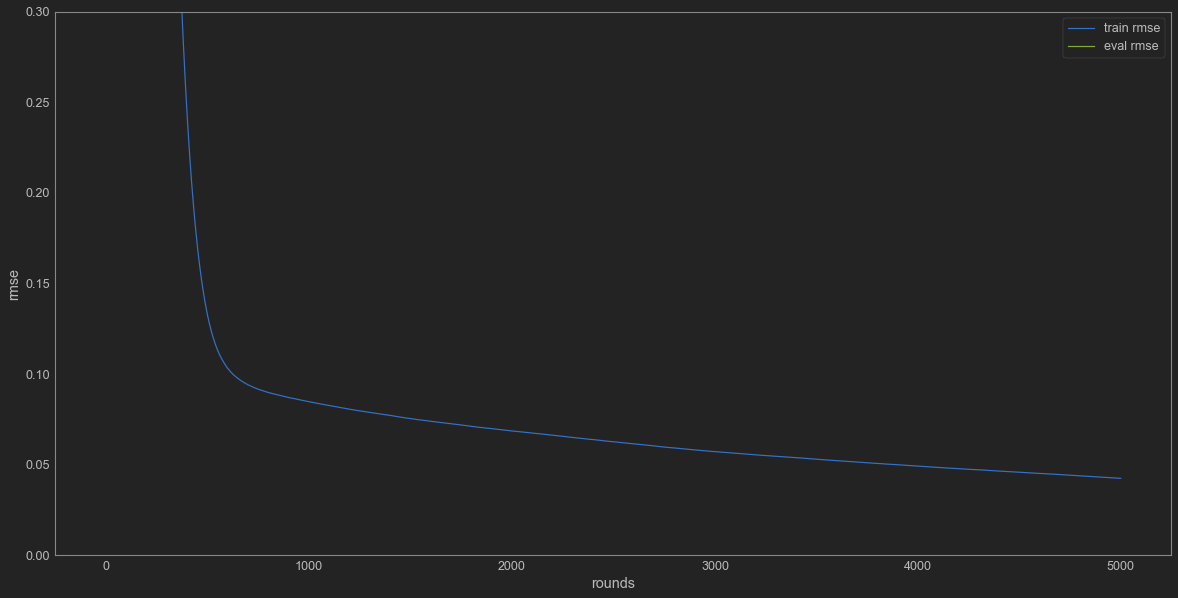

In [18]:
#学習曲線を可視化する
plt.figure(figsize=(20, 10))
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.ylim(0, 0.3)
plt.show()

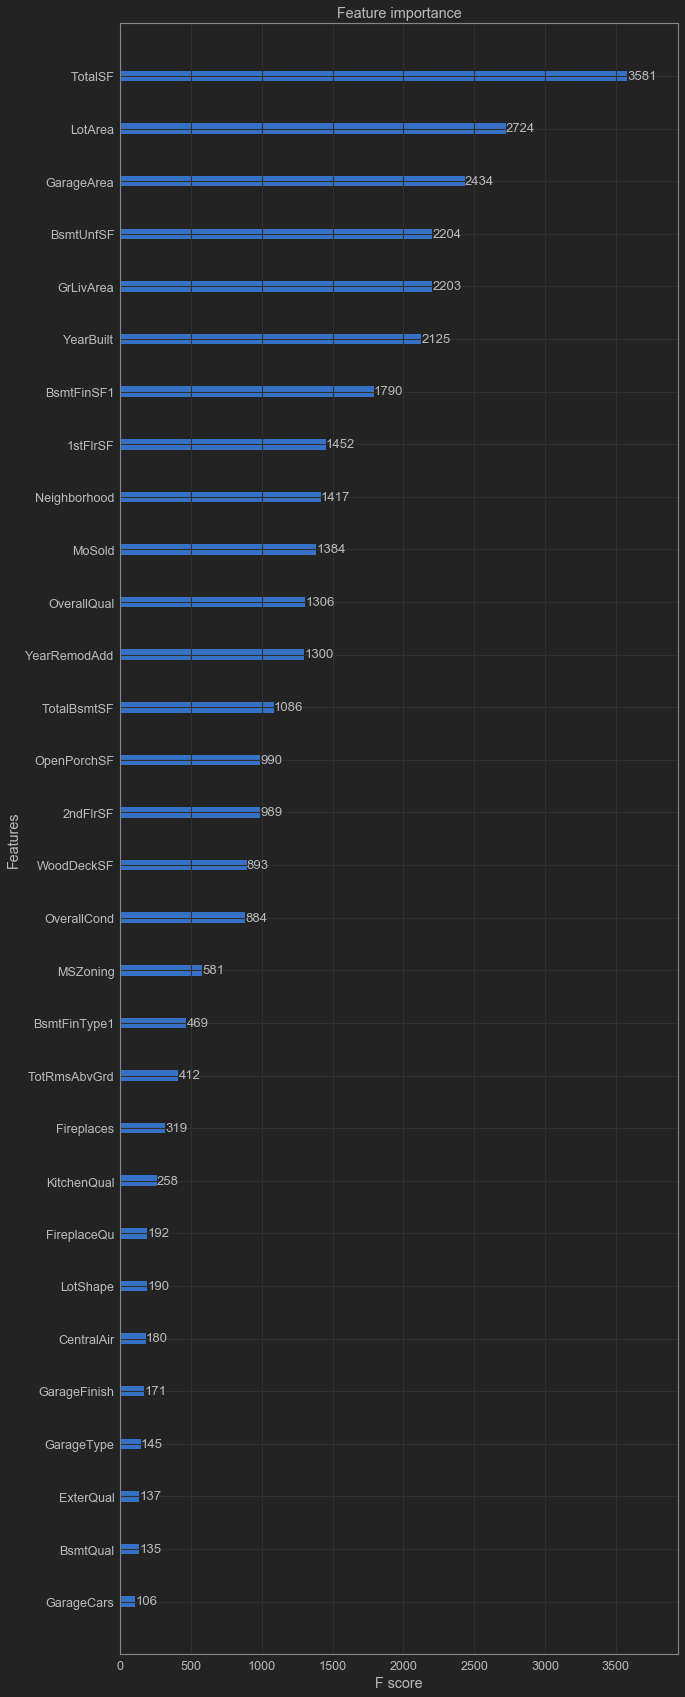

In [19]:
#特徴量ごとの重要度を可視化する
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(10, 30)

In [20]:
print(Z_test.shape,X_train.shape)

(1459, 30) (1168, 30)


In [21]:
dtest = xgb.DMatrix(Z_test)
my_submission = pd.DataFrame()
my_submission["Id"] = test_ID
my_submission["SalePrice"] = np.exp(bst.predict(dtest))
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)